# NMS Algorithms Implementation and Evaluation

In [10]:
import numpy as np
import time
import random
import os
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from PIL import Image
from ultralytics import YOLO
import pandas as pd

# Set random seed for reproducibility
random.seed(42)


## 1. NMS Algorithms Implementation

In [11]:
def iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) between two bounding boxes.

    Args:
        box1: Tuple (x1, y1, x2, y2)
        box2: Tuple (x1, y1, x2, y2)

    Returns:
        float: IoU value between 0 and 1
    """
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    area1 = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    area2 = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    union = area1 + area2 - intersection
    return intersection / union if union > 0 else 0


def classic_nms(detections, iou_threshold):
    """
    Classic Non-Maximum Suppression algorithm.

    Args:
        detections: List of tuples (x1, y1, x2, y2, score)
        iou_threshold: Threshold for overlapping detection suppression

    Returns:
        List: Filtered detections
    """
    detections = sorted(detections, key=lambda x: x[4], reverse=True)
    final_detections = []

    while detections:
        best = detections.pop(0)
        final_detections.append(best)
        detections = [det for det in detections if iou(best, det) < iou_threshold]

    return final_detections


def soft_nms(detections, iou_threshold, sigma=0.006):
    """
    Soft Non-Maximum Suppression algorithm.

    Args:
        detections: List of tuples (x1, y1, x2, y2, score)
        iou_threshold: Threshold for score adjustment
        sigma: Parameter for Gaussian suppression

    Returns:
        List: Filtered detections with adjusted scores
    """
    detections = sorted(detections, key=lambda x: x[4], reverse=True)

    for i in range(len(detections)):
        for j in range(i + 1, len(detections)):
            iou_val = iou(detections[i], detections[j])
            if iou_val > iou_threshold:
                detections[j] = (
                    detections[j][0],
                    detections[j][1],
                    detections[j][2],
                    detections[j][3],
                    detections[j][4] * np.exp(-(iou_val ** 2) / sigma)
                )

    return [det for det in detections if det[4] > 0]


def adaptive_nms(detections, iou_threshold, density_threshold=0.998):
    """
    Adaptive Non-Maximum Suppression algorithm.

    Args:
        detections: List of tuples (x1, y1, x2, y2, score)
        iou_threshold: Base IoU threshold
        density_threshold: Density threshold for adaptive adjustment

    Returns:
        List: Filtered detections
    """
    def density(det, all_detections):
        overlaps = [iou(det, other) for other in all_detections if other != det]
        return max(overlaps) if overlaps else 0

    detections = sorted(detections, key=lambda x: x[4], reverse=True)
    final_detections = []

    while detections:
        current = detections.pop(0)
        current_density = density(current, detections)
        threshold = iou_threshold if current_density <= density_threshold else current_density

        final_detections.append(current)
        detections = [det for det in detections if iou(current, det) < threshold]

    return final_detections


def hashing_nms(detections, iou_threshold, alpha=15):
    """
    Hashing-based Non-Maximum Suppression algorithm.

    Args:
        detections: List of tuples (x1, y1, x2, y2, score)
        iou_threshold: Not used in this implementation (kept for consistency)
        alpha: Hashing parameter

    Returns:
        List: Filtered detections
    """
    grid = {}
    final_detections = []

    for det in detections:
        hash_key = (int(det[0] // alpha), int(det[1] // alpha))
        if hash_key not in grid or grid[hash_key][4] < det[4]:
            grid[hash_key] = det

    final_detections.extend(grid.values())
    return final_detections


def inverted_nms(detections, iou_threshold):
    """
    Inverted Non-Maximum Suppression algorithm.

    Args:
        detections: List of tuples (x1, y1, x2, y2, score)
        iou_threshold: Threshold for overlapping detection suppression

    Returns:
        List: Filtered detections
    """
    detections = sorted(detections, key=lambda x: x[4])
    discarded_detections = []

    for i in range(len(detections)):
        for j in range(i + 1, len(detections)):
            if iou(detections[i], detections[j]) > iou_threshold:
                discarded_detections.append(detections[i])
                break

    return [det for det in detections if det not in discarded_detections]


## 2. Synthetic Data Performance Test

In [12]:
def generate_fake_detections(num_detections, img_size=(1000, 1000)):
    """Generate random detections for testing purposes."""
    detections = []
    for _ in range(num_detections):
        x1 = random.randint(0, img_size[0] - 100)
        y1 = random.randint(0, img_size[1] - 100)
        x2 = x1 + random.randint(50, 100)
        y2 = y1 + random.randint(50, 100)
        score = random.uniform(0.5, 1.0)
        detections.append((x1, y1, x2, y2, score))
    return detections


def test_algorithms():
    """Test performance of all NMS algorithms on synthetic data."""
    algorithms = {
        "Classic NMS": classic_nms,
        "Soft NMS": soft_nms,
        "Adaptive NMS": adaptive_nms,
        "Hashing NMS": hashing_nms,
        "Inverted NMS": inverted_nms,
    }

    iou_threshold = 0.5
    count_fake_picture = 100000
    list_detections = [generate_fake_detections(random.randint(5, 50)) for _ in range(count_fake_picture)]

    results = []
    for name, algorithm in algorithms.items():
        print(f"Testing {name}...")
        start_time = time.time()
        for detections in list_detections:
            _ = algorithm(detections, iou_threshold)
        execution_time = time.time() - start_time
        print(f"Execution Time for {name}: {execution_time:.4f} seconds")
        results.append({"Algorithm": name, "Time (s)": execution_time})

    return pd.DataFrame(results)


# Run performance test
performance_results = test_algorithms()
performance_results


Testing Classic NMS...
Execution Time for Classic NMS: 28.2814 seconds
Testing Soft NMS...
Execution Time for Soft NMS: 30.0509 seconds
Testing Adaptive NMS...
Execution Time for Adaptive NMS: 56.0407 seconds
Testing Hashing NMS...
Execution Time for Hashing NMS: 0.4149 seconds
Testing Inverted NMS...
Execution Time for Inverted NMS: 28.6396 seconds


,Algorithm,Time (s)
0,Classic NMS,28.281395
1,Soft NMS,30.050889
2,Adaptive NMS,56.040678
3,Hashing NMS,0.414854
4,Inverted NMS,28.639551


## 3. Evaluation on Real Datasets (CrowdHuman and MED)

In [15]:
class DatasetEvaluator:
    """Class for evaluating NMS algorithms on specific datasets."""

    def __init__(self, dataset_name, images_path, labels_path, model_path, confidence_threshold=0.25):
        self.dataset_name = dataset_name
        self.images_path = images_path
        self.labels_path = labels_path
        self.model_path = model_path
        self.confidence_threshold = confidence_threshold
        self.model = YOLO(model_path)

        # Add dataset-specific parameters
        self.class_filter = 0 if dataset_name == "CrowdHuman" else None

    def yolo_to_xyxy(self, label, img_width, img_height):
        """Convert YOLO format to (x1, y1, x2, y2) coordinates."""
        cls, x_center, y_center, width, height = label
        x1 = (x_center - width / 2) * img_width
        y1 = (y_center - height / 2) * img_height
        x2 = (x_center + width / 2) * img_width
        y2 = (y_center + height / 2) * img_height
        return [x1, y1, x2, y2]

    def load_ground_truth(self, label_path, img_width, img_height):
        """Load ground truth boxes from YOLO format label file."""
        if not os.path.exists(label_path):
            return []
        with open(label_path, "r") as f:
            labels = [list(map(float, line.split())) for line in f]
        return [self.yolo_to_xyxy(label, img_width, img_height) for label in labels]

    def evaluate(self, predictions, ground_truths, iou_threshold=0.5):
        """Calculate precision, recall and F1-score."""
        true_positives = 0
        matched_gt = set()

        for pred in predictions:
            for i, gt in enumerate(ground_truths):
                if i not in matched_gt and iou(pred, gt) > iou_threshold:
                    true_positives += 1
                    matched_gt.add(i)
                    break

        false_positives = len(predictions) - true_positives
        false_negatives = len(ground_truths) - true_positives

        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        return precision, recall, f1

    def run_evaluation(self, iou_threshold=0.5):
        """Evaluate all NMS algorithms on the dataset."""
        algorithms = {
            "Classic NMS": classic_nms,
            "Soft NMS": soft_nms,
            "Adaptive NMS": adaptive_nms,
            "Hashing NMS": hashing_nms,
            "Inverted NMS": inverted_nms,
        }

        test_images = [os.path.join(self.images_path, img) for img in os.listdir(self.images_path)
                      if img.endswith(('.jpg', '.png'))]

        results = []

        for img_path in test_images:
            img = Image.open(img_path)
            img_width, img_height = img.size

            label_file = os.path.join(self.labels_path,
                                    os.path.splitext(os.path.basename(img_path))[0] + ".txt")
            ground_truths = self.load_ground_truth(label_file, img_width, img_height)

            # Get model predictions with class filter if needed
            prediction = self.model(img_path,
                                  conf=self.confidence_threshold,
                                  iou=1,
                                  classes=self.class_filter,
                                  verbose=False)  # Only class 0 for CrowdHuman
            boxes = prediction[0].boxes.xyxy.cpu().numpy()
            scores = prediction[0].boxes.conf.cpu().numpy()
            detections = [(x1, y1, x2, y2, score) for (x1, y1, x2, y2), score in zip(boxes, scores)]

            for name, algorithm in algorithms.items():
                filtered_detections = algorithm(detections, iou_threshold)
                filtered_boxes = [det[:4] for det in filtered_detections]
                precision, recall, f1 = self.evaluate(filtered_boxes, ground_truths)

                results.append({
                    "Dataset": self.dataset_name,
                    "Algorithm": name,
                    "Precision": precision,
                    "Recall": recall,
                    "F1-Score": f1
                })

        results_df = pd.DataFrame(results)
        average_results = results_df.groupby(["Dataset", "Algorithm"]).mean().reset_index()

        # Save results
        output_file = f"{self.dataset_name}_nms_evaluation_results.csv"
        results_df.to_csv(output_file, index=False)

        return average_results

# Evaluation

In [16]:
crowdhuman_evaluator = DatasetEvaluator(
    dataset_name="CrowdHuman",
    images_path="CrowdHuman/test/images",
    labels_path="CrowdHuman/test/labels",
    model_path="yolov8n"
)
crowdhuman_results = crowdhuman_evaluator.run_evaluation()

# Evaluate on MED dataset
med_evaluator = DatasetEvaluator(
    dataset_name="MED",
    images_path="MED/train/images",
    labels_path="MED/train/labels",
    model_path="MED/best.pt"
)
med_results = med_evaluator.run_evaluation()

# Combine and display results
combined_results = pd.concat([crowdhuman_results, med_results])
combined_results

,Dataset,Algorithm,Precision,Recall,F1-Score
0,CrowdHuman,Adaptive NMS,0.880842,0.459221,0.564859
1,CrowdHuman,Classic NMS,0.884622,0.459069,0.565829
2,CrowdHuman,Hashing NMS,0.607506,0.478681,0.475519
3,CrowdHuman,Inverted NMS,0.887812,0.455154,0.563927
4,CrowdHuman,Soft NMS,0.875388,0.459718,0.564676
0,MED,Adaptive NMS,0.684853,0.962671,0.787137
1,MED,Classic NMS,0.686795,0.962671,0.788477
2,MED,Hashing NMS,0.574339,0.964237,0.708130
3,MED,Inverted NMS,0.687462,0.961869,0.788580
4,MED,Soft NMS,0.686173,0.962491,0.787956


## 4. Precision-Recall Curves for Both Datasets

In [17]:
class PRCurveGenerator:
    """Class for generating Precision-Recall curves for NMS algorithms."""

    def __init__(self, dataset_name, images_path, labels_path, model_path, confidence_threshold=0.01):
        self.dataset_name = dataset_name
        self.images_path = images_path
        self.labels_path = labels_path
        self.model_path = model_path
        self.confidence_threshold = confidence_threshold
        self.model = YOLO(model_path)
        self.class_filter = 0 if dataset_name == "CrowdHuman" else None

    def yolo_to_xyxy(self, label, img_w, img_h):
        """Convert YOLO format to (x1, y1, x2, y2) coordinates."""
        cls, x, y, w, h = label
        x1 = (x - w / 2) * img_w
        y1 = (y - h / 2) * img_h
        x2 = (x + w / 2) * img_w
        y2 = (y + h / 2) * img_h
        return [x1, y1, x2, y2]

    def load_ground_truth(self, label_path, img_w, img_h):
        """Load ground truth boxes from YOLO format label file."""
        if not os.path.exists(label_path):
            return []
        with open(label_path, "r") as f:
            labels = [list(map(float, line.split())) for line in f]
        return [self.yolo_to_xyxy(label, img_w, img_h) for label in labels]

    def match_predictions(self, predictions, ground_truths, iou_threshold):
        """Match predictions to ground truth and generate binary labels and scores."""
        y_true = []
        y_scores = []

        for pred in predictions:
            pred_box = pred[:4]
            score = pred[4]
            matched = any(iou(pred_box, gt) > iou_threshold for gt in ground_truths)
            y_true.append(1 if matched else 0)
            y_scores.append(score)

        return y_true, y_scores

    def generate_pr_curves(self, iou_threshold=0.5):
        """Generate Precision-Recall curves for all NMS algorithms."""
        nms_methods = {
            "Classic NMS": classic_nms,
            "Soft NMS": soft_nms,
            "Adaptive NMS": adaptive_nms,
            "Hashing NMS": hashing_nms,
            "Inverted NMS": inverted_nms,
        }

        image_files = [f for f in os.listdir(self.images_path)
                      if f.lower().endswith(('.jpg', '.png'))]

        pr_curves = {}

        for method_name, nms_func in nms_methods.items():
            print(f"Processing {method_name} for {self.dataset_name}...")
            all_y_true = []
            all_y_scores = []

            for img_name in image_files:
                img_path = os.path.join(self.images_path, img_name)
                label_path = os.path.join(self.labels_path,
                                        os.path.splitext(img_name)[0] + ".txt")

                # Load image and ground truth
                image = Image.open(img_path)
                width, height = image.size
                gt_boxes = self.load_ground_truth(label_path, width, height)

                # Get model predictions with class filter
                preds = self.model(img_path,
                                 conf=self.confidence_threshold,
                                 iou=1,
                                 classes=self.class_filter,
                                 verbose=False)[0]  # Only class 0 for CrowdHuman
                if not preds.boxes:
                    continue

                boxes = preds.boxes.xyxy.cpu().numpy()
                confs = preds.boxes.conf.cpu().numpy()
                detections = [(*box, conf) for box, conf in zip(boxes, confs)]

                # Apply NMS
                filtered_preds = nms_func(detections, iou_threshold)

                # Match predictions to ground truth
                y_true, y_scores = self.match_predictions(filtered_preds, gt_boxes, iou_threshold)
                all_y_true.extend(y_true)
                all_y_scores.extend(y_scores)

            # Calculate PR curve
            if all_y_true and all_y_scores:
                precision, recall, _ = precision_recall_curve(all_y_true, all_y_scores)
                pr_curves[method_name] = (precision, recall)

        return pr_curves

    def plot_pr_curves(self, pr_curves):
        """Plot Precision-Recall curves."""
        plt.figure(figsize=(10, 8))
        for method, (precision, recall) in pr_curves.items():
            plt.plot(recall, precision, label=method)

        plt.title(f"Precision-Recall Curves ({self.dataset_name})")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend()
        plt.grid(True)

        # Save and show plot
        output_file = f"{self.dataset_name}_precision_recall_curve.png"
        plt.savefig(output_file)
        plt.show()

# Generate and plot PR curves for CrowdHuman

Processing Classic NMS for CrowdHuman...
Processing Soft NMS for CrowdHuman...
Processing Adaptive NMS for CrowdHuman...
Processing Hashing NMS for CrowdHuman...
Processing Inverted NMS for CrowdHuman...


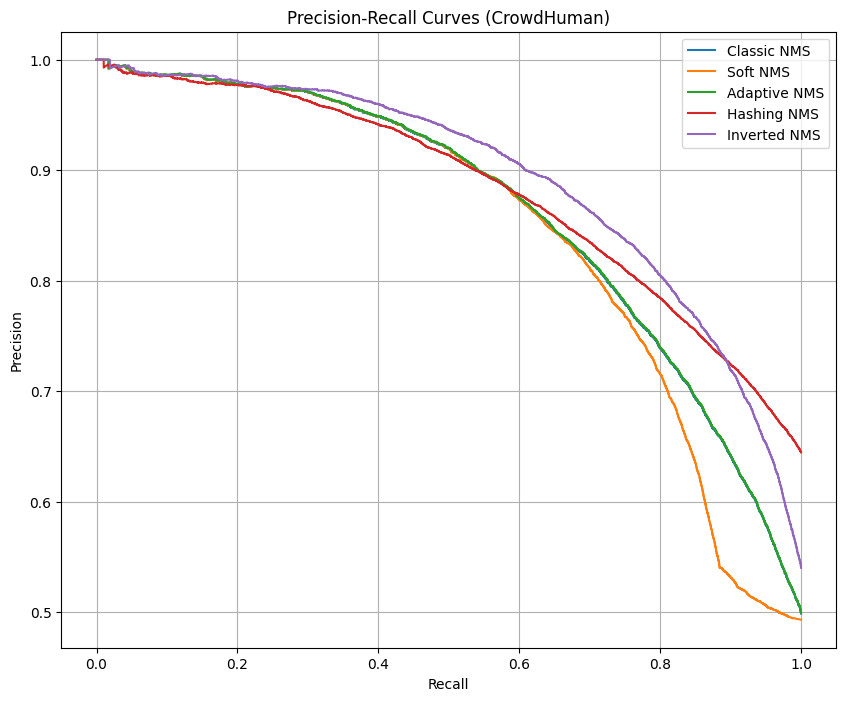

Processing Classic NMS for MED...
Processing Soft NMS for MED...
Processing Adaptive NMS for MED...
Processing Hashing NMS for MED...
Processing Inverted NMS for MED...


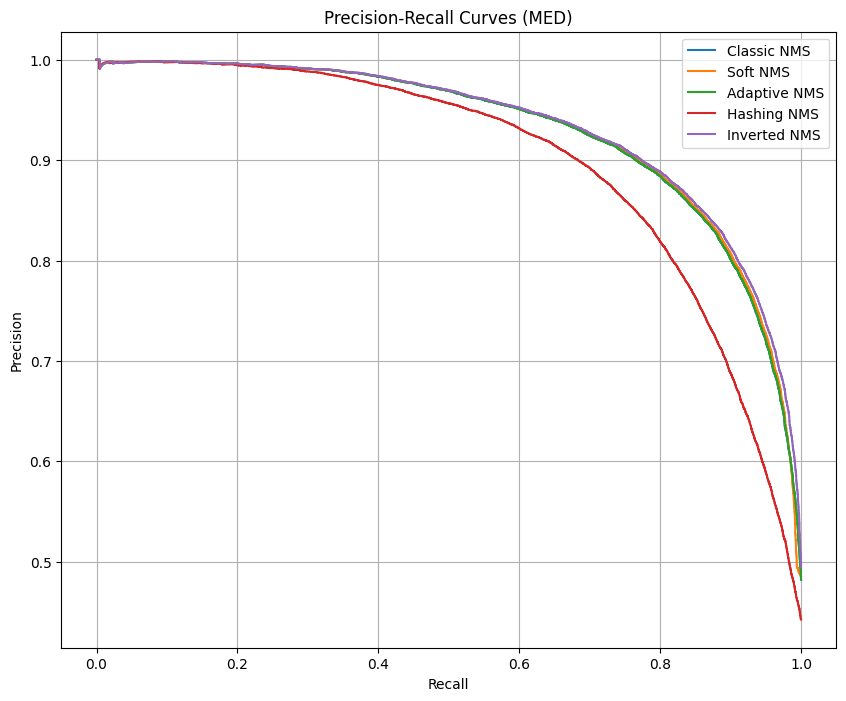

In [18]:
crowdhuman_pr = PRCurveGenerator(
    dataset_name="CrowdHuman",
    images_path="CrowdHuman/test/images",
    labels_path="CrowdHuman/test/labels",
    model_path="yolov8n"
)
crowdhuman_curves = crowdhuman_pr.generate_pr_curves()
crowdhuman_pr.plot_pr_curves(crowdhuman_curves)

# Generate and plot PR curves for MED
med_pr = PRCurveGenerator(
    dataset_name="MED",
    images_path="MED/train/images",
    labels_path="MED/train/labels",
    model_path="MED/best.pt"
)
med_curves = med_pr.generate_pr_curves()
med_pr.plot_pr_curves(med_curves)